# Phasespace

This is an example of plotting phase space distributions.
First, create a simple line, a tracker and a particle set:

In [1]:
%load_ext autoreload
%autoreload 2

import xtrack as xt
import xpart as xp
import xplt
import numpy as np

np.random.seed(43543557)

xplt.apply_style()

In [2]:
## Generate a simple 6-fold symmetric FODO lattice

n = 6  # number of sections
elements = {
    "QF": xt.Multipole(length=0.3, knl=[0, +0.63]),
    "QD": xt.Multipole(length=0.3, knl=[0, -0.48]),
    "MU": xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
}
parts = {
    "a": [xt.Node(0.7, "QF"), xt.Node(1.4, "MU"), xt.Node(2.1, "QD"), xt.Node(2.8, "MU")],
    "b": [xt.Node(2.2, "MU"), xt.Node(2.9, "QD"), xt.Node(3.6, "MU"), xt.Node(4.3, "QF")],
}
nodes = [xt.Node(5.0 * i, "a" if i % 2 else "b", name=f"S{i+1}") for i in range(n)]

line = xt.Line.from_sequence(
    nodes, length=5.0 * n, sequences=parts, elements=elements, auto_reorder=True
)
line = line.cycle(4)
line.particle_ref = xp.Particles()
line.build_tracker();

Found suitable prebuilt kernel `default_only_xtrack`.


In [3]:
## Generate particles
nparticles = int(1e4)

# Transverse distribution (gaussian)
norm_emitt_x = 4e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_x)
norm_emitt_y = 1e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_y)
x, px = xp.generate_2D_gaussian(nparticles)
y, py = xp.generate_2D_gaussian(nparticles)

# Longitudinal distribution (coasting beam)
rel_momentum_spread = 1e-4  # relative momentum spread ( P/p0 - 1 )
zeta = line.get_length() * np.random.uniform(-0.5, 0.5, nparticles)
delta = rel_momentum_spread * xp.generate_2D_gaussian(nparticles)[0]

particles = line.build_particles(
    x_norm=x,
    px_norm=px,
    nemitt_x=norm_emitt_x,
    y_norm=y,
    py_norm=py,
    nemitt_y=norm_emitt_y,
    method="4d",  # for twiss (default is 6d, won't work without a cavity)
    zeta=zeta,
    delta=delta,
)

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


## Default phasespace plot

Create a default {class}`PhasespacePlot <xplt.phasespace.PhaseSpacePlot>`:

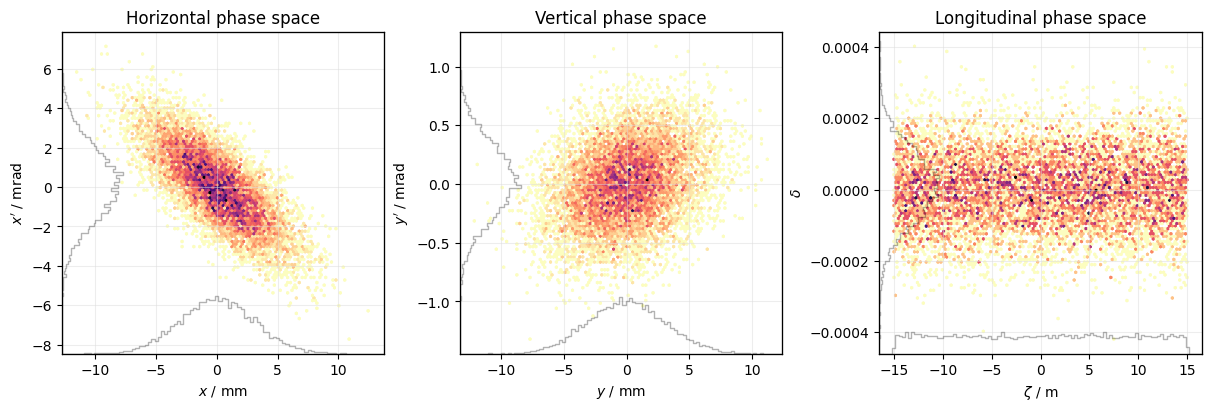

In [4]:
plot = xplt.PhaseSpacePlot(particles)

## Customisation

Use the parameter `kind` to specify what is plotted as a comma separated list of pairs `a-b`.
The properties `a` and `b` can be any property of a particle, such as the default ones below or a custom property (see {doc}`/examples/properties`).   
Note that `zeta` is the absolute value, while `zeta_wrapped` is the wrapped value in range (-circumference/2 ; +circumference/2).

In [5]:
print("Default properties:", ", ".join(xplt.properties._default_properties))
print("Derived properties:", ", ".join(plot._default_properties.keys()))

Default properties: at_turn, s, x, px, y, py, delta, zeta, tau, ptau, pzeta, energy, chi, charge_ratio, q0, mass0, betx, bety, alfx, alfy, gamx, gamy, mux, muy, dx, dy, dpx, dpy, count, x_mean, y_mean, x_std, y_std, q, m
Derived properties: zeta_wrapped, X, Y, Px, Py, Jx, Jy, Θx, Θy, t


```{tip}
The `kind=` parameter accepts abbreviations for common pairs, e.g. `x` for `x-px`, `z` for `zeta-delta` or `Y` for `Y-Py`
```

Here we also add some ellipses to indicate standard deviation and percentiles, disable the default projections, and use a scatter plot with some transparency.
See {class}`PhasespacePlot <xplt.phasespace.PhaseSpacePlot>` for details.

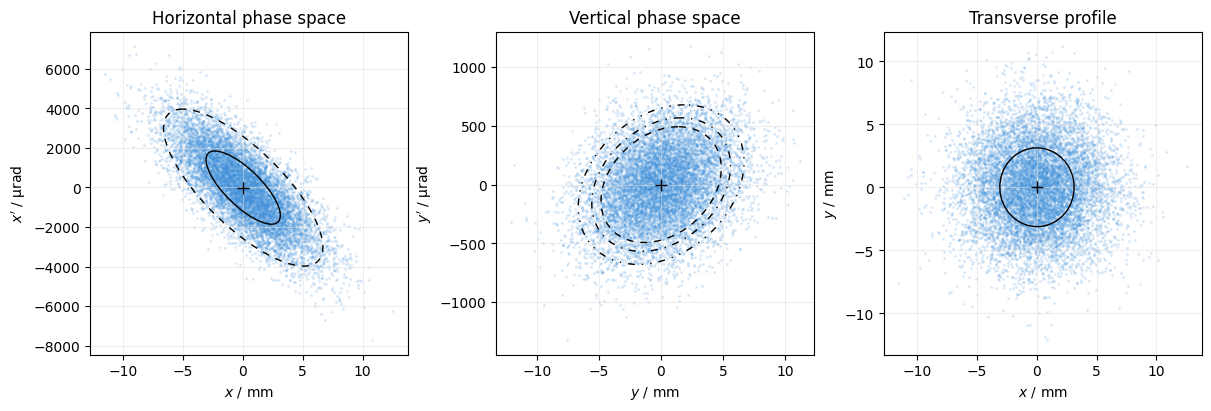

In [6]:
plot = xplt.PhaseSpacePlot(
    particles,
    mask=particles.particle_id < 1e4,
    kind="x,y,x-y",
    plot="scatter",  # using a scatter plot instead of a 2D histogram
    scatter_kwargs=dict(alpha=0.2),  # scatter plot with semi-transparent color
    projections=False,  # No projections onto axes
    display_units=dict(p="urad"),  # p as shorthand for px and py
    mean=True,  # show mean cross for all
    std=[True, None, True],  # show std ellipse for first and last
    percentiles=[[90], [70, 80, 90], None],  # show some percentile ellipses
)
plot.ax[2].set(title="Transverse profile");

```{tip}
Most parameters accept a list of values to specify different values for each subplot
```

## Normalized coordinates

Calculate twiss parameters for normalization:

In [7]:
tw = line.twiss(
    method="4d", at_elements=np.unique(particles.at_element)  # twiss at location of particles
)

Use uppercase letters for normalized coordinates (`X` is the shorthand for `X-Px`):

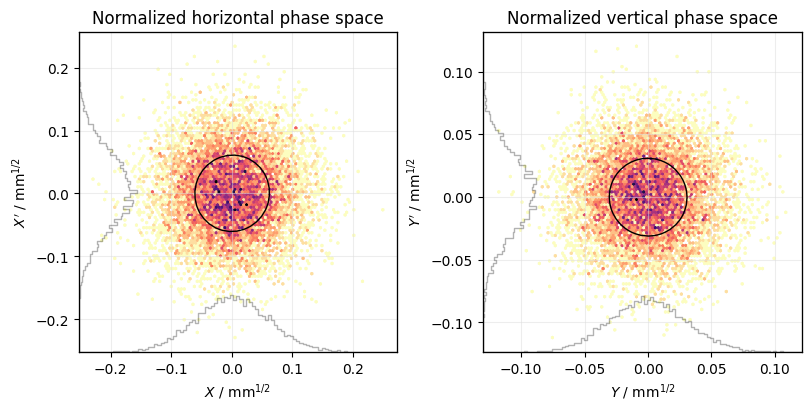

In [8]:
plot = xplt.PhaseSpacePlot(particles, kind="X,Y-Py", twiss=tw, std=True)

## Color by 3rd coordinate

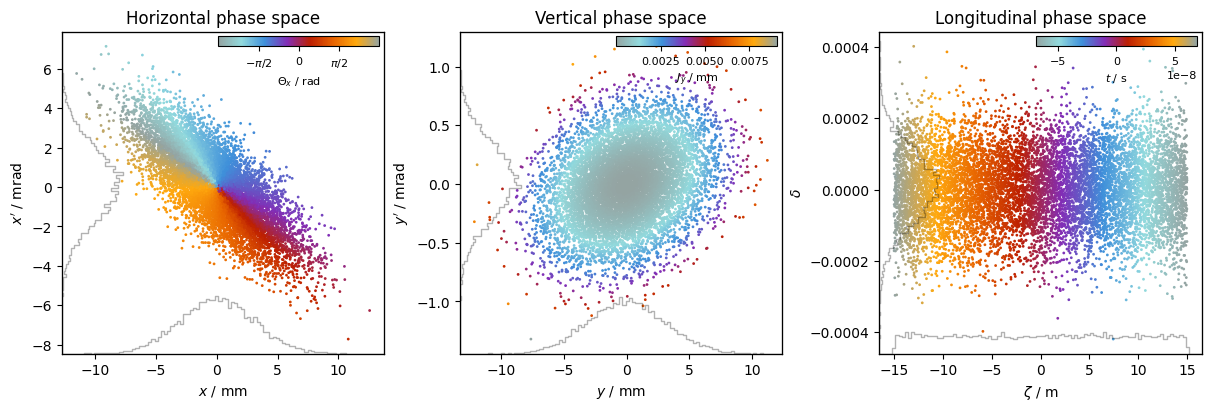

In [9]:
plot = xplt.PhaseSpacePlot(
    particles,
    "x,y,zeta_wrapped-delta",
    color="Θx,Jy,t",  # <-- color by value
    cmap="petroff_cyclic",
    cbar_loc="inside upper right",
    twiss=tw,
    grid=False,
)

## Monitor data

Track the particle for a couple of turns:

In [10]:
line.track(particles, num_turns=100, turn_by_turn_monitor=True)

Use `mask=` to select a subset of the data to plot, e.g. a single turn:

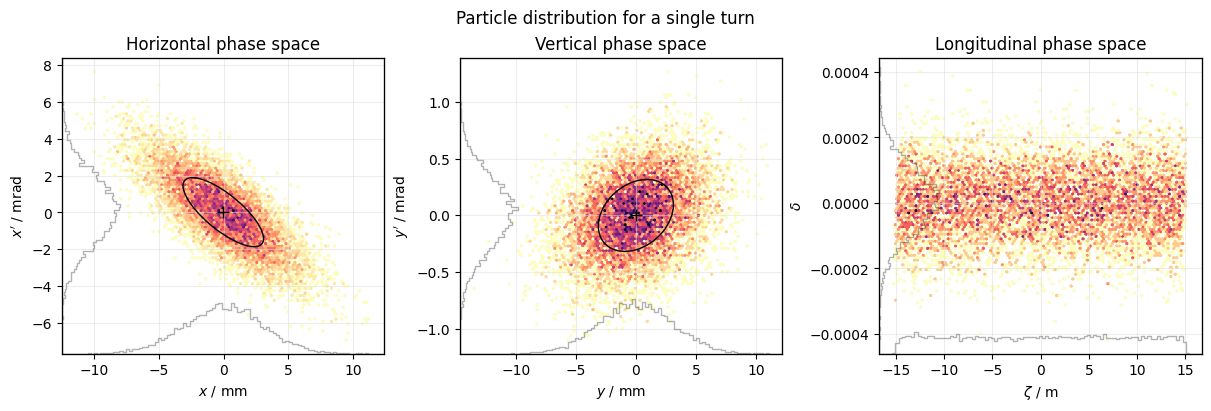

In [11]:
plot = xplt.PhaseSpacePlot(
    line.record_last_track,
    mask=(slice(None), 83),  # select all particles and turn 83
    mean=(1, 1, 0),
    std=(1, 1, 0),
)
plot.fig.suptitle("Particle distribution for a single turn");

Use `masks=` to set a different mask for each subplot:

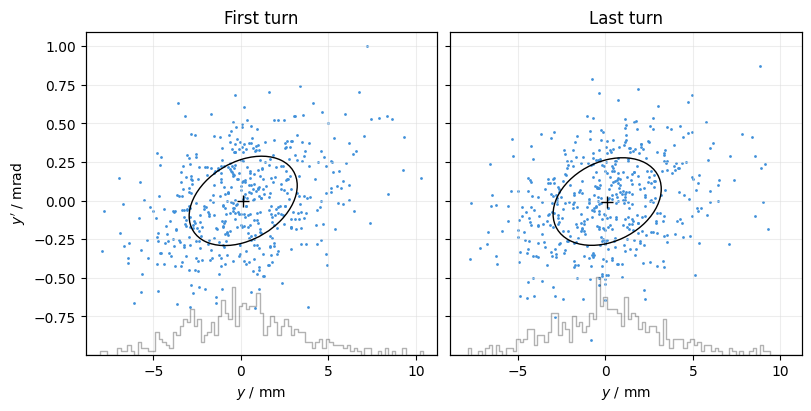

In [12]:
plot = xplt.PhaseSpacePlot(
    line.record_last_track,
    kind="y,y",
    titles=("First turn", "Last turn"),
    sharex="all",
    sharey="all",
    masks=[(slice(500), 0), (slice(500), -1)],  # select 500 particles at first and last turn
    projections="x",
    mean=True,
    std=True,
)
plot.ax[1].set(ylabel=None);

Plot the trace of some particles:

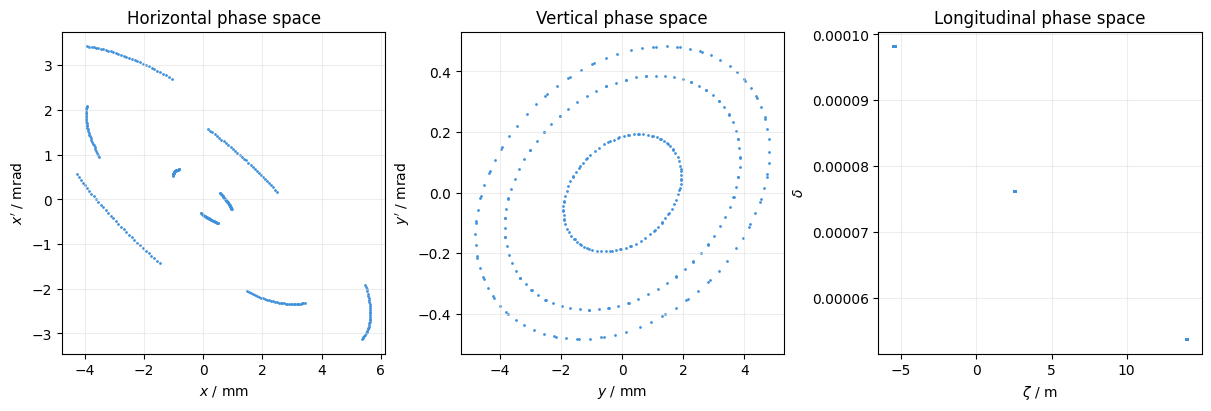

In [13]:
plot = xplt.PhaseSpacePlot(
    line.record_last_track,
    mask=([17, 18, 21], slice(None)),  # select particles 17,18,21 and all turns
    projections=False,
)

Plot the trace of some particles as distinct plots on the same axis:

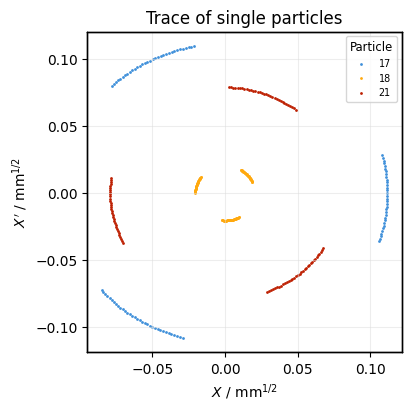

In [14]:
particle_indices = (17, 18, 21)
ax = None

for particle_i in particle_indices:
    plot = xplt.PhaseSpacePlot(
        line.record_last_track,
        mask=(particle_i, slice(None)),  # select particle i and all turns
        kind="X",
        twiss=tw,
        titles=("Trace of single particles",),
        ax=ax,  # draw on same plot as before
    )
    ax = plot.ax

ax.legend(particle_indices, title="Particle");

-----------------
```{seealso}
- {class}`xplt.phasespace`
```